<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> Laboratorio 3 - Contexto</h2>
    <h2> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> 2025-1</h2>
</center>

Correr el siguiente bloque solo 1 vez

In [1]:
!pip install pillow

In [2]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy.ndimage import convolve1d
from scipy.linalg import toeplitz

# Laboratorio 3: Modelado de desenfoque en imágenes mediante operadores lineales

En este laboratorio exploraremos el proceso de desenfoque de una imagen utilizando operadores lineales en forma de **matrices de convolución**, específicamente matrices Toeplitz construidas a partir de un núcleo Gaussiano.

El desenfoque de una imagen es una operación fundamental en procesamiento de imágenes y se puede modelar matemáticamente como una multiplicación matricial. En lugar de aplicar una función de convolución tradicional sobre una imagen, representaremos el desenfoque mediante una **operación lineal separable**, en la que una imagen bidimensional es multiplicada por matrices que difuminan por **filas** y por **columnas**.

Adicionalmente, se agregará **ruido** a la imagen desenfocada, con el objetivo de obtener una versión degradada de la imagen original.

El enfoque principal de este laboratorio, y el desafío que se plantea, consiste en que ustedes logren **restaurar la imagen degradada** aplicando conceptos de álgebra lineal. Para ello, deberán utilizar **operaciones matriciales** junto con las propiedades de la **descomposición en valores singulares (SVD)**, con el fin de reconstruir una versión lo más **cercana** posible de la imagen original.

El procedimiento de desenfoque se modela con las matrices $A_c$ y $A_r$, las cuales operan sobre las columnas y filas de la imagen $X_{true}$, respectivamente. 
Es decir:
$$
\underbrace{A_c\,X_{\text{true}}\,A_r^\top}_{\displaystyle{B_{\text{true}}}} + \Xi = B_{\text{data}},
$$
donde:
- $X_{\text{true}}$: imagen original (en escala de grises).
- $A_c$ : matriz que aplica el desenfoque por columnas.
- $A_r$: matriz que aplica el desenfoque por filas.
- $\Xi$: ruido Gaussiano aditivo asociado al proceso de captura de la imagen.
- $B_{\text{true}}$: imagen desenfocada resultante sin considerar el ruido $\Xi$.
- $B_{\text{data}}$: imagen degradada que se quiere corregir. Esta es la data que se tiene a disposición.

Ambas matrices  $A_c$ y $A_r $ son construidas a partir de un filtro gaussiano discreto, y suelen ser matrices Toeplitz simétricas, y por simplicidad se usará $A_c=A_r$.

Este enfoque no solo permite aplicar desenfoques, sino también estudiar su inversión, lo que se utilizará más adelante para **restauración de imágenes** .

---

Funcion que retorna las 2 matrices de convolución $A_c$ y $A_r$:

In [3]:
# Construcción de operadores de 'desenfoque'
def blur_operator(m, n, bl=1):
    """
    Descripción: Genera los operadores de convolución 1-D empleados
    ---------- 
    inputs:
    ----------
    m, n : int
        Dimensiones de la imagen (filas = m, columnas = n).
    bl : {1, 2}
        1  → blur simétrico  (σ_r = σ_c = 0.01)
        2  → blur asimétrico (σ_r = 0.02, σ_c = 0.01)
    ----------
    outputs:
    ----------
    Ac : ndarray (m, m)
        Matriz Toeplitz que difumina horizontalmente (columnas).
    Ar : ndarray (n, n)
        Matriz Toeplitz que difumina verticalmente (filas).
    """
    # --- 1. Parámetros ----------------------------------------------------
    sigmac = 0.01
    sigmar = 0.02 if bl == 2 else sigmac
    # --- 2. Nucleos 1-D ---------------------------------------------------
    c_pos = np.linspace(0, 1, m) # coordenadas normalizadas
    r_pos = np.linspace(0, 1, n)

    c = np.exp(-0.5 * (c_pos / sigmac) ** 2)
    r = np.exp(-0.5 * (r_pos / sigmar) ** 2)
    # umbral 1e-4 
    c[c < 1e-4] = 0.0
    r[r < 1e-4] = 0.0

    # Normalización: división por (2·sum − valor central)
    c /= (2 * c.sum() - c[0])
    r /= (2 * r.sum() - r[0])
    # --- 3. Matrices Toeplitz --------------------------------------------
    Ac = toeplitz(c)          # (m × m)
    Ar = toeplitz(r)          # (n × n)
    return Ac, Ar


Cargamos la imagen y la desenfocamos

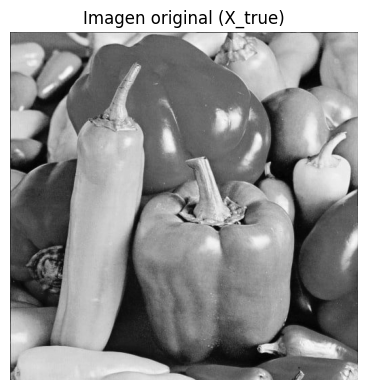

In [4]:
# Paso 1: Cargar imagen original y convertir a escala de grises
img = Image.open("img.jpg").convert("L")
img = img.resize((512, 512))
X_true = np.array(img) / 255.0  # Imagen original normalizada

# Mostrar imagen original
plt.figure(figsize=(5,4))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Imagen original (X_true)')
plt.tight_layout()
plt.show()

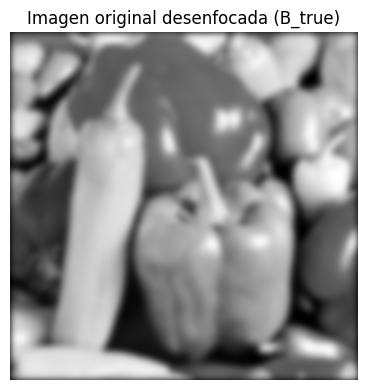

In [5]:
# Paso 2: Definir el operador de desenfoque
Ac, Ar = blur_operator(512, 512, bl=1)

# Paso 3: Aplicar el operador de desenfoque
B_blur = Ac @ X_true @ Ar.T

# Mostrar imagen desenfocada
plt.figure(figsize=(5,4))
plt.imshow(B_blur, cmap='gray')
plt.axis('off')
plt.title('Imagen original desenfocada (B_true)')
plt.tight_layout()
plt.show()

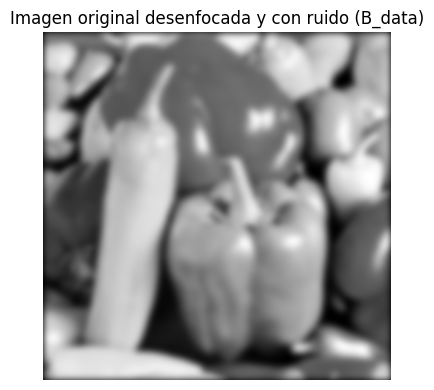

In [6]:
# Paso 4: Cargar ruido definido previamente
ruido=np.load('ruido.npy')  # Ruido gaussiano dado

# Paso 5: Agregar ruido a la imagen desenfocada
B_data = B_blur + ruido

# Mostrar imagen desenfocada más ruido Gaussiano
plt.figure(figsize=(5,4))
plt.imshow(B_blur, cmap='gray')
plt.axis('off')
plt.title('Imagen original desenfocada y con ruido (B_data)')
plt.tight_layout()
plt.show()

### Pasos para la reconstrucción

Para la realización de la reconstrucción de una **aproximación** la imagen $X_{\text{true}}$ desde la imagen $B$ se puede realizar _despejando_ $X_{\text{true}}$, es decir,
$$
\begin{align*}
    A_c\,X_{\text{true}}\,A_r^\top+\Xi &=B_{\text{data}},\tag{1.1}\\
    A_c\,X_{\text{true}}\,A_r^\top &=B_{\text{data}}-\Xi,\\
    X_{\text{true}}\,A_r^\top &=A_c^{-1}\left(B_{\text{data}}-\Xi\right),\\
    X_{\text{true}} &=A_c^{-1}\,\left(B_{\text{data}}-\Xi\right)\,A_r^{-\top},\\
    X_{\text{true}} &=\left(A_c^{-1}\,B_{\text{data}}-A_c^{-1}\,\Xi\right)\,A_r^{-\top},\\
    X_{\text{true}} &=A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}-A_c^{-1}\,\Xi\,A_r^{-\top}.\tag{1.2}
\end{align*}$$
Esto nos indica que si computamos $A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}$ directamente no obtendremos $X_{\text{true}}$ dado que desconocemos el término $\Xi$.
Incluso podemos determinar que la diferencia entre $X_{\text{true}}$ y $A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}$ es exactamente $-A_c^{-1}\,\Xi\,A_r^{-\top}$, y si calculamos una norma matricial de la diferencia se obtiene,
$$
    \left\|X_{\text{true}}-A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}\right\| = \left\|A_c^{-1}\,\Xi\,A_r^{-\top}\right\|.
$$
Entonces, para poder lograr reducir esta diferencia entre la imagen original $X_{\text{true}}$ y la imagen reconstruida se propone el siguiente procedimiento:
1. Descomponer el operador $A_c^{-1}$, es decir $A_c^{-1}=A_{c,\text{trunc}}^{-1}+A_{c,\text{res}}^{-1}$
2. Descomponer el operador $A_r^{-\top}$, es decir $A_r^{-\top}=A_{r,\text{trunc}}^{-\top}+A_{r,\text{res}}^{-\top}$

donde `trunc` denota el truncamiento del operador y `res` denota el residuo resultante del truncamiento.
El siguiente paso corresponde a reemplazar la descomposición de los operadores en el término $A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}$ de la ecuación (1.2), es decir,
$$
\begin{align*}
    A_c^{-1}\,B_{\text{data}}\,A_r^{-\top} &= \left(A_{c,\text{trunc}}^{-1}+A_{c,\text{res}}^{-1}\right)
                                                B_{\text{data}}
                                                \left(A_{r,\text{trunc}}^{-\top}+A_{r,\text{res}}^{-\top}\right)\\
                                            &= A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}+\Lambda_{\text{res}}, \tag{1.3}
\end{align*}
$$
donde 
$\Lambda_{\text{res}}=
A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{res}}^{-\top}
+A_{c,\text{res}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}
+A_{c,\text{res}}^{-1}\,B_{\text{data}}\,A_{r,\text{res}}^{-\top}$.
Notar que si no existe truncamiento, entonces la matriz $\Lambda_{\text{res}}$ sería la matriz nula.
Entonces, reemplazando la descomposición (1.3) en la ecuación (1.2) se obtiene,
$$
\begin{align*}
    X_{\text{true}} &= A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}-A_c^{-1}\,\Xi\,A_r^{-\top}\\
                    &= \underbrace{A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}}_{\displaystyle{X_{\text{recon}}}}+\Lambda_{\text{res}}-A_c^{-1}\,\Xi\,A_r^{-\top}.
\end{align*}
$$
Ahora, denotando $X_{\text{recon}}=A_{c,\text{trunc}}^{-1}\,B_{\text{data}}\,A_{r,\text{trunc}}^{-\top}$ como la imagen reconstruida, podemos obtener nuevamente la norma de la diferencia entre la imagen original y la imagen reconstruida de la siguiente forma,
$$
\begin{align*}
    \left\|X_{\text{true}}-X_{\text{recon}}\right\|=\left\|\Lambda_{\text{res}}-A_c^{-1}\,\Xi\,A_r^{-\top}\right\|.
\end{align*}
$$
Por lo tanto, si el truncamiento es exitoso se puede lograr que el error de la reconstrucción por medio de truncamiento sea menor que utilizar los operadores originales, es decir, estudiaremos las condiciones para que esto se logre lo siguiente,
$$
\left\|\Lambda_{\text{res}}-A_c^{-1}\,\Xi\,A_r^{-\top}\right\|=\left\|X_{\text{true}}-X_{\text{recon}}\right\|\leq\left\|X_{\text{true}}-A_c^{-1}\,B_{\text{data}}\,A_r^{-\top}\right\|= \left\|A_c^{-1}\,\Xi\,A_r^{-\top}\right\|.
$$
El éxito del procedimiento implica que se obtiene una imagen más cercana a la original por medio del truncamiento que utilizar los operadores sin truncar.
_Este procedimiento de aproximación es lo que se estudiará en el laboratorio_.

**Su objetivo será implementar esta expresión paso a paso utilizando operaciones matriciales y aplicar la descomposición SVD para obtener la mejor estimación posible de la imagen original para la problemática particular que se le entregue.**

### Funciones que seran utilizadas


Funcion `np.linalg.svd(A, full_matrices=False)` --> obtiene la descomposicion en valores singulares (svd) de la matriz A.

In [7]:
A = np.array([[1., 2., 3.],
              [4., 5., 6.],
              [7., 8., 9.]])

Uc, Sc, VcT = np.linalg.svd(A, full_matrices=False)
print('Uc:',Uc)
print('Sc:',Sc)
print('VcT:',VcT)


Uc: [[-0.21483724  0.88723069  0.40824829]
 [-0.52058739  0.24964395 -0.81649658]
 [-0.82633754 -0.38794278  0.40824829]]
Sc: [1.68481034e+01 1.06836951e+00 4.41842475e-16]
VcT: [[-0.47967118 -0.57236779 -0.66506441]
 [-0.77669099 -0.07568647  0.62531805]
 [-0.40824829  0.81649658 -0.40824829]]


Funcion `np.argsort()` --> obtiene los i`dices originales ordenados de los mayores o menores elementos.

In [8]:
a = np.array([30, 10, 50, 20])

# Obtener los índices que ordenarían el array
indices_ordenados = np.argsort(a)

print("Índices ordenados menor a mayor:", indices_ordenados)  # [1 3 0 2]
print("Array ordenado:", a[indices_ordenados])  # [10 20 30 50]

indices_ordenados = np.argsort(a)[::-1]
print("Índices ordenados de mayor a menor:", indices_ordenados)  # [2 0 3 1]
print("Array ordenado:", a[indices_ordenados])  # [10 20 30 50]

n_indices_ordenados= np.argsort(a)[::-1][:2] #n=2
print("Los primeros n indices ordenados de mayor a menor:", n_indices_ordenados)  # [2 0]
print("Array ordenado:", a[n_indices_ordenados])  # [50 30]


Índices ordenados menor a mayor: [1 3 0 2]
Array ordenado: [10 20 30 50]
Índices ordenados de mayor a menor: [2 0 3 1]
Array ordenado: [50 30 20 10]
Los primeros n indices ordenados de mayor a menor: [2 0]
Array ordenado: [50 30]


Funcion `.ravel()` --> aplana un arreglo multidimensional, conviritendolo en un arreglo plano 1D, cada fila se concatena con la que sigue.

In [ ]:
A = np.array([[1., 2., 3.],
              [4., 5., 6.],
              [7., 8., 9.]])

r = A.ravel()
print(r)

# funciona solo como vista, es decir, no se copia el array y A no se modifica, sigue siendo una matriz
print(A)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]


Funcion `np.zeros_like(A,dtype)` --> crea una matriz de ceros de la misma dimension que A.

In [10]:
copy=np.zeros_like(A)
print(copy)
#matriz booleana
copy=np.zeros_like(A, dtype=bool)
print(copy)


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[False False False]
 [False False False]
 [False False False]]


Funciones utilizadas en conjunto


In [11]:
# Quiero marcar los primeros 3 elementos de la matriz mas grandes y dividirlo por 2

indices_ordenados = np.argsort(A.ravel())[::-1][:3]
print(A.ravel()[indices_ordenados], "\n")
B=A.ravel()[indices_ordenados] / 2
print(B,"\n")

# Dejar solo los 3 elementos que dividi por 2 en una matriz
Acopy = np.zeros_like(A)
Acopy.ravel()[indices_ordenados] = B
print("Matriz con los 3 elementos que dividi por 2")
print(Acopy,"\n")

# Dejar todos lo elementos mas los que dividi por 2
A.ravel()[indices_ordenados] = B
print("Matriz con los 3 elementos que dividi por 2")
print(A,"\n")    

[9. 8. 7.] 

[4.5 4.  3.5] 

Matriz con los 3 elementos que dividi por 2
[[0.  0.  0. ]
 [0.  0.  0. ]
 [3.5 4.  4.5]] 

Matriz con los 3 elementos que dividi por 2
[[1.  2.  3. ]
 [4.  5.  6. ]
 [3.5 4.  4.5]] 

